In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-ss/data_fold0.zip

In [3]:
ls

__notebook__.ipynb  data_fold0/


In [4]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [5]:
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 64
EPOCHS = 50

SAMPLE = None
CONDITIONS = ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'



In [6]:
# rm -rf val_fold0

In [7]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [8]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [9]:
fold_df = pd.read_csv('/kaggle/input/lsdc-fold-split/5folds.csv')

In [10]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [11]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)
#     raise ValueError('Condition not found '+ lev)

In [12]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [13]:
# train_df = train_df.dropna()

In [14]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [15]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [16]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [17]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [18]:
# study_id = 4003253 
# series_id = 2448190387
# instance_num = 28

ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [19]:
# label_df[['study_id', 'series_id']].drop_duplicates()

In [20]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [21]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [22]:
id2label

{0: 'left_subarticular_stenosis_l1_l2_normal/mild',
 1: 'left_subarticular_stenosis_l1_l2_moderate',
 2: 'left_subarticular_stenosis_l1_l2_severe',
 3: 'left_subarticular_stenosis_l2_l3_normal/mild',
 4: 'left_subarticular_stenosis_l2_l3_moderate',
 5: 'left_subarticular_stenosis_l2_l3_severe',
 6: 'left_subarticular_stenosis_l3_l4_normal/mild',
 7: 'left_subarticular_stenosis_l3_l4_moderate',
 8: 'left_subarticular_stenosis_l3_l4_severe',
 9: 'left_subarticular_stenosis_l4_l5_normal/mild',
 10: 'left_subarticular_stenosis_l4_l5_moderate',
 11: 'left_subarticular_stenosis_l4_l5_severe',
 12: 'left_subarticular_stenosis_l5_s1_normal/mild',
 13: 'left_subarticular_stenosis_l5_s1_moderate',
 14: 'left_subarticular_stenosis_l5_s1_severe',
 15: 'right_subarticular_stenosis_l1_l2_normal/mild',
 16: 'right_subarticular_stenosis_l1_l2_moderate',
 17: 'right_subarticular_stenosis_l1_l2_severe',
 18: 'right_subarticular_stenosis_l2_l3_normal/mild',
 19: 'right_subarticular_stenosis_l2_l3_moderat

In [23]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

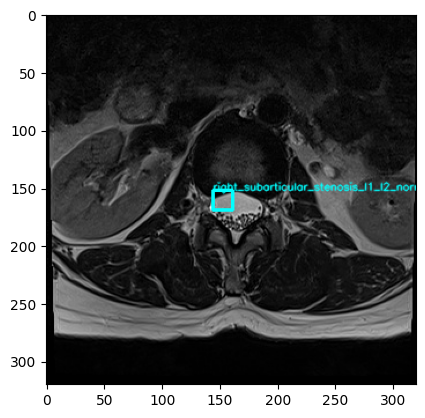

In [24]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)
fontFace = cv2.FONT_HERSHEY_SIMPLEX


for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [25]:
# ls data_fold0/labels/val

In [26]:
# os.path.join(_ANN_DIR, name+'.txt')

In [27]:
# cat 'train_fold0/labels/404602713_1230697721_12.txt'

In [28]:
# Install the ultralytics package from GitHub
!pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-xcl3bgzs
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-xcl3bgzs
  Resolved https://github.com/ultralytics/ultralytics.git to commit e48a42ec5dbbed3b3a8a95e6ab10ab0eeea4e518
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for ultralytics: filename=ultralytics-8.3.32-py3-none-any.whl size=887032 sha256=ab978acbb489bf82df7c4e755d92b1710a497501fce57ca3f5c0d406791ddbca
  Stored in directory: /tmp/pip-ephem-wheel-cache-nub1vrav/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics


In [29]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: left_subarticular_stenosis_l1_l2_normal/mild
1: left_subarticular_stenosis_l1_l2_moderate
2: left_subarticular_stenosis_l1_l2_severe
3: left_subarticular_stenosis_l2_l3_normal/mild
4: left_subarticular_stenosis_l2_l3_moderate
5: left_subarticular_stenosis_l2_l3_severe
6: left_subarticular_stenosis_l3_l4_normal/mild
7: left_subarticular_stenosis_l3_l4_moderate
8: left_subarticular_stenosis_l3_l4_severe
9: left_subarticular_stenosis_l4_l5_normal/mild
10: left_subarticular_stenosis_l4_l5_moderate
11: left_subarticular_stenosis_l4_l5_severe
12: left_subarticular_stenosis_l5_s1_normal/mild
13: left_subarticular_stenosis_l5_s1_moderate
14: left_subarticular_stenosis_l5_s1_severe
15: right_subarticular_stenosis_l1_l2_normal/mild
16: right_subarticular_stenosis_l1_l2_moderate
17: right_subarticular_stenosis_l1_l2_severe
18: right_subarticular_stenosis_l2_l3_normal/mild
19: right_subarticular_stenosis_l2_l3_moderate
20: right_subarticular_stenosis_l2_l3_severe
21: right_subarticular_stenosis

In [30]:
ls

__notebook__.ipynb  data_fold0/


In [31]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0 # dataset root dir
train: images/train  
val: images/val 
test: images/val 

# Classes
names:
    0: left_subarticular_stenosis_l1_l2_normal/mild
    1: left_subarticular_stenosis_l1_l2_moderate
    2: left_subarticular_stenosis_l1_l2_severe
    3: left_subarticular_stenosis_l2_l3_normal/mild
    4: left_subarticular_stenosis_l2_l3_moderate
    5: left_subarticular_stenosis_l2_l3_severe
    6: left_subarticular_stenosis_l3_l4_normal/mild
    7: left_subarticular_stenosis_l3_l4_moderate
    8: left_subarticular_stenosis_l3_l4_severe
    9: left_subarticular_stenosis_l4_l5_normal/mild
    10: left_subarticular_stenosis_l4_l5_moderate
    11: left_subarticular_stenosis_l4_l5_severe
    12: left_subarticular_stenosis_l5_s1_normal/mild
    13: left_subarticular_stenosis_l5_s1_moderate
    14: left_subarticular_stenosis_l5_s1_severe
    15: right_subarticular_stenosis_l1_l2_normal/mild
    16: right_subarticular_stenosis_l1_l2_moderate
    17: right_subarticular_stenosis_l1_l2_severe
    18: right_subarticular_stenosis_l2_l3_normal/mild
    19: right_subarticular_stenosis_l2_l3_moderate
    20: right_subarticular_stenosis_l2_l3_severe
    21: right_subarticular_stenosis_l3_l4_normal/mild
    22: right_subarticular_stenosis_l3_l4_moderate
    23: right_subarticular_stenosis_l3_l4_severe
    24: right_subarticular_stenosis_l4_l5_normal/mild
    25: right_subarticular_stenosis_l4_l5_moderate
    26: right_subarticular_stenosis_l4_l5_severe
    27: right_subarticular_stenosis_l5_s1_normal/mild
    28: right_subarticular_stenosis_l5_s1_moderate
    29: right_subarticular_stenosis_l5_s1_severe
  

Writing yolo_scs.yaml


In [32]:
from ultralytics import YOLO


# Initialize YOLO Model
model = YOLO('/kaggle/input/yolov11x/other/default/1/yolo11x.pt')
            
config = {
    'data': "/kaggle/working/yolo_scs.yaml",
    'imgsz': 384,
    'batch': 16,
    'epochs': 100,
    'patience': 15,
    'device': '0,1',
    'workers': 8,
    'project': 'spine_detection',
    'name': 'Subarticular_Stenosis_yolo',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'verbose': True,
    'seed': 42,
    'deterministic': True,
    'dropout': 0.2,
    'lr0': 0.001,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 10,
    'warmup_momentum': 0.8,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'close_mosaic': 10,
    'amp': True,
}

results = model.train(**config)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.32 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/yolov11x/other/default/1/yolo11x.pt, data=/kaggle/working/yolo_scs.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=384, save=True, save_period=-1, cache=False, device=0,1, workers=8, project=spine_detection, name=Subarticular_Stenosis_yolo, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]
2024-11-17 05:40:40,169	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-17 05:40:41,276	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=30

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 60.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data_fold0/labels/train... 11016 images, 5 backgrounds, 0 corrupt: 100%|██████████| 11016/11016 [00:09<00:00, 1173.20it/s]


train: New cache created: /kaggle/working/data_fold0/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val... 2726 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2726/2726 [00:02<00:00, 1168.76it/s]


val: New cache created: /kaggle/working/data_fold0/labels/val.cache
Plotting labels to spine_detection/Subarticular_Stenosis_yolo/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to spine_detection/Subarticular_Stenosis_yolo
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.76G      2.131       2.96      1.051          6        384: 100%|██████████| 689/689 [03:58<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:39<00:00,  4.31it/s]


                   all       2726       3856      0.382      0.194      0.102     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.69G      1.935      2.325      0.987          7        384: 100%|██████████| 689/689 [03:48<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.54it/s]


                   all       2726       3856       0.47      0.289      0.199     0.0891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.78G      1.831        2.2     0.9647          7        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.57it/s]


                   all       2726       3856      0.357       0.25      0.167     0.0723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.68G      1.822      2.171     0.9621          7        384: 100%|██████████| 689/689 [03:31<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.54it/s]


                   all       2726       3856      0.468      0.334      0.227     0.0985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.78G      1.806      2.154      0.955          3        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.449      0.357       0.22     0.0929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.72G      1.744      2.059     0.9464          5        384: 100%|██████████| 689/689 [03:22<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.439      0.373      0.255       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.74G      1.732      2.034     0.9468         15        384: 100%|██████████| 689/689 [03:23<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.267       0.38      0.233      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.77G      1.713      2.028     0.9419          9        384: 100%|██████████| 689/689 [03:23<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.49it/s]


                   all       2726       3856      0.358      0.408      0.264      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.67G      1.695      1.969     0.9342         13        384: 100%|██████████| 689/689 [03:20<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.279      0.402      0.265      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.77G       1.67      1.939     0.9359          6        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.54it/s]


                   all       2726       3856      0.334      0.444      0.309      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.76G      1.678      1.906      0.932          4        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856       0.32      0.429      0.312      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.75G      1.641      1.887     0.9249          4        384: 100%|██████████| 689/689 [03:18<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.54it/s]


                   all       2726       3856      0.302      0.456      0.305      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.67G      1.632      1.855     0.9245          6        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.277      0.452      0.296      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.77G      1.633      1.847     0.9286          9        384: 100%|██████████| 689/689 [03:18<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.50it/s]


                   all       2726       3856      0.325      0.466      0.332      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.75G      1.617      1.832     0.9218         12        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.299      0.455      0.303      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.76G      1.618      1.806     0.9201          7        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.49it/s]


                   all       2726       3856      0.395       0.44      0.332      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.67G      1.596      1.811     0.9191          7        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.54it/s]


                   all       2726       3856      0.331      0.496       0.35      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.77G      1.602      1.788     0.9179          9        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.54it/s]


                   all       2726       3856      0.333      0.481      0.339      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.76G      1.593      1.769     0.9161          6        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.373      0.467      0.337      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.75G      1.593      1.778      0.916          7        384: 100%|██████████| 689/689 [03:18<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.55it/s]


                   all       2726       3856      0.292        0.5      0.341      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.67G      1.578      1.757     0.9132          9        384: 100%|██████████| 689/689 [03:17<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.54it/s]


                   all       2726       3856      0.344      0.458      0.338      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.77G      1.584      1.743     0.9169         10        384: 100%|██████████| 689/689 [03:17<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.347       0.48      0.359      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.76G      1.586      1.709     0.9139          7        384: 100%|██████████| 689/689 [03:18<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856       0.36      0.537      0.412      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.76G      1.575      1.708     0.9141          7        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.411      0.548       0.42      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.67G      1.551      1.648     0.9071         10        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.50it/s]


                   all       2726       3856      0.373      0.579      0.417      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.77G      1.556      1.649     0.9097          5        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.417      0.561      0.439      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.75G      1.563      1.623     0.9137         11        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.47it/s]


                   all       2726       3856      0.404      0.558      0.436      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.75G      1.558      1.632     0.9135          6        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.50it/s]


                   all       2726       3856      0.411      0.575      0.435      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.67G      1.553      1.635     0.9132          4        384: 100%|██████████| 689/689 [03:18<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.384       0.59      0.426      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.76G      1.542      1.583     0.9079          4        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.404      0.568      0.449      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.75G      1.544      1.596     0.9081          4        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856       0.41      0.576      0.439      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.76G      1.538      1.577     0.9059          7        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.434      0.551       0.43      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.67G      1.539      1.586     0.9089         11        384: 100%|██████████| 689/689 [03:18<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.436      0.566      0.453      0.223


  0%|          | 0/689 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.77G      1.538      1.591     0.9111          9        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.49it/s]


                   all       2726       3856      0.414       0.58      0.433      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.76G      1.541      1.571     0.9085          3        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.422      0.566      0.445      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.75G      1.523      1.552     0.9058          4        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.431      0.589      0.455      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.67G       1.53      1.538      0.906         12        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.50it/s]


                   all       2726       3856      0.425      0.585      0.445       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.76G      1.519      1.567     0.9045          5        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.421      0.587      0.452      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.76G      1.526      1.541     0.9033          6        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.50it/s]


                   all       2726       3856       0.43      0.577      0.459      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.75G      1.535      1.541     0.9079         11        384: 100%|██████████| 689/689 [03:21<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856       0.44      0.562      0.441      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.67G      1.515      1.553     0.9035         10        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.433      0.581      0.448      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.77G       1.53      1.532     0.9073          6        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.398      0.556      0.443      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.76G      1.508      1.534     0.9023          7        384: 100%|██████████| 689/689 [03:18<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.48it/s]


                   all       2726       3856       0.43      0.581      0.458       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.75G      1.512      1.506     0.9031          6        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.50it/s]


                   all       2726       3856      0.438      0.573      0.448      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.67G      1.515       1.51     0.9012         10        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.424        0.6      0.452      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.77G      1.494      1.511     0.9006         14        384: 100%|██████████| 689/689 [03:21<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.49it/s]


                   all       2726       3856       0.41      0.602      0.449      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.76G      1.514      1.499     0.9052         13        384: 100%|██████████| 689/689 [03:22<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.48it/s]


                   all       2726       3856      0.421       0.59       0.45      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.76G      1.494      1.494     0.9012          9        384: 100%|██████████| 689/689 [03:21<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856       0.42       0.59      0.453       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.67G      1.486      1.468     0.8989          9        384: 100%|██████████| 689/689 [03:21<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.47it/s]


                   all       2726       3856      0.423      0.595      0.455      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.77G        1.5      1.496     0.8994          4        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.48it/s]


                   all       2726       3856      0.431      0.585      0.461      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.75G      1.495      1.473     0.8995          9        384: 100%|██████████| 689/689 [03:21<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.48it/s]


                   all       2726       3856      0.447      0.598      0.462      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.75G      1.487      1.461     0.9022          4        384: 100%|██████████| 689/689 [03:22<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.442       0.58      0.453      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.67G      1.482      1.465     0.8992          5        384: 100%|██████████| 689/689 [03:21<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.413      0.584      0.456      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.77G      1.498      1.459     0.9025          7        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.50it/s]


                   all       2726       3856      0.451      0.581       0.45      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.75G      1.492      1.444     0.9009          9        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.49it/s]


                   all       2726       3856       0.41      0.591      0.456       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.75G      1.485      1.456      0.899         20        384: 100%|██████████| 689/689 [03:21<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.45it/s]


                   all       2726       3856       0.43      0.595      0.469      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.66G      1.481      1.451        0.9          6        384: 100%|██████████| 689/689 [03:20<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.50it/s]


                   all       2726       3856      0.426      0.601      0.465      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.77G      1.474      1.446        0.9          9        384: 100%|██████████| 689/689 [03:21<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.47it/s]


                   all       2726       3856      0.439      0.605      0.468      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.76G       1.48      1.439     0.9009          6        384: 100%|██████████| 689/689 [03:21<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.428       0.61      0.466      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.75G      1.481      1.428     0.9025         10        384: 100%|██████████| 689/689 [03:21<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.44it/s]


                   all       2726       3856      0.424      0.626      0.467      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.67G      1.472      1.458     0.8955          9        384: 100%|██████████| 689/689 [03:23<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.49it/s]


                   all       2726       3856      0.424      0.628      0.467      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.77G      1.467      1.421     0.8973          9        384: 100%|██████████| 689/689 [03:21<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.50it/s]


                   all       2726       3856      0.432      0.624      0.468      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.77G      1.466      1.429     0.8994          8        384: 100%|██████████| 689/689 [03:20<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.48it/s]


                   all       2726       3856      0.429      0.621      0.471      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.75G      1.469      1.417     0.8976          6        384: 100%|██████████| 689/689 [03:21<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.50it/s]


                   all       2726       3856      0.434      0.619      0.472      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.67G      1.465      1.397     0.8944          5        384: 100%|██████████| 689/689 [03:21<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.438       0.63      0.475      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.76G      1.451      1.391     0.8944          4        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.46it/s]


                   all       2726       3856      0.448      0.618      0.475      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.76G      1.455      1.409      0.895         17        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.453      0.618      0.473      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.75G      1.452      1.394     0.8958          8        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.449      0.615      0.477      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.67G      1.461      1.398     0.8943          9        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.445      0.615      0.476      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.78G      1.448      1.373     0.8953         11        384: 100%|██████████| 689/689 [03:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.51it/s]


                   all       2726       3856      0.447      0.615      0.476      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.75G      1.443      1.387     0.8939          2        384: 100%|██████████| 689/689 [03:20<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.49it/s]


                   all       2726       3856      0.444      0.616      0.477      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.75G      1.446      1.381     0.8949          8        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.435      0.624      0.478      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.68G      1.457      1.372     0.8966         11        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.50it/s]


                   all       2726       3856      0.422       0.62      0.463      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.76G      1.442      1.357     0.8936          3        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.56it/s]


                   all       2726       3856      0.431      0.612      0.463      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.76G      1.431      1.363     0.8906          9        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.48it/s]


                   all       2726       3856      0.431      0.612      0.464      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.75G      1.427      1.354     0.8917          3        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.53it/s]


                   all       2726       3856      0.434      0.605      0.462      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.67G      1.423      1.359     0.8895         11        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.50it/s]


                   all       2726       3856      0.448      0.607      0.477      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.77G      1.439      1.354      0.891          7        384: 100%|██████████| 689/689 [03:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.56it/s]


                   all       2726       3856      0.448      0.604      0.477      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.75G      1.417      1.343     0.8899          4        384: 100%|██████████| 689/689 [03:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.45it/s]


                   all       2726       3856      0.447      0.607      0.476      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.75G       1.42      1.364     0.8908          7        384: 100%|██████████| 689/689 [03:20<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.56it/s]


                   all       2726       3856      0.447      0.603      0.477      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.67G      1.416      1.341     0.8866         11        384: 100%|██████████| 689/689 [03:20<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:37<00:00,  4.52it/s]


                   all       2726       3856      0.448      0.604      0.478      0.236
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 66, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

81 epochs completed in 5.444 hours.
Optimizer stripped from spine_detection/Subarticular_Stenosis_yolo/weights/last.pt, 114.4MB
Optimizer stripped from spine_detection/Subarticular_Stenosis_yolo/weights/best.pt, 114.4MB

Validating spine_detection/Subarticular_Stenosis_yolo/weights/best.pt...
Ultralytics 8.3.32 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 464 layers, 56,861,674 parameters, 0 gradients, 194.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [00:38<00:00,  4.46it/s]


                   all       2726       3856      0.448      0.617      0.475      0.237
left_subarticular_stenosis_l1_l2_normal/mild        349        349      0.596      0.871      0.636      0.302
left_subarticular_stenosis_l1_l2_moderate         15         15      0.356        0.4      0.448      0.294
left_subarticular_stenosis_l1_l2_severe          4          4      0.225       0.25      0.215     0.0825
left_subarticular_stenosis_l2_l3_normal/mild        316        316      0.567      0.886      0.659      0.346
left_subarticular_stenosis_l2_l3_moderate         49         49      0.405      0.612      0.461       0.25
left_subarticular_stenosis_l2_l3_severe         12         12      0.259      0.417      0.347      0.176
left_subarticular_stenosis_l3_l4_normal/mild        254        254      0.537      0.866      0.661      0.357
left_subarticular_stenosis_l3_l4_moderate        100        100      0.429      0.617      0.436      0.248
left_subarticular_stenosis_l3_l4_severe   

right_subarticular_stenosis_l4_l5_normal/mild


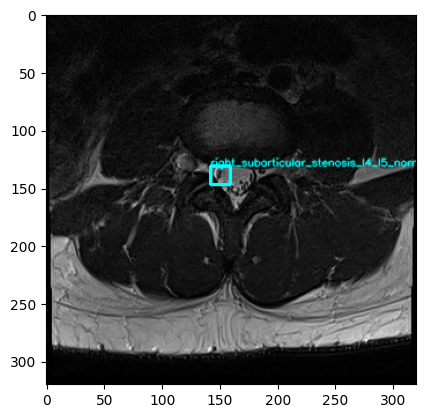

In [33]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name+'.jpg')

im = plt.imread(path).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    print(label)
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [34]:
# Initialize YOLO Model
model = YOLO(glob.glob("/kaggle/working/spine_detection/Subarticular_Stenosis_yolo/weights/best.pt")[0])
out = model.predict([path], save=True, conf=0.2)



0: 384x384 1 left_subarticular_stenosis_l4_l5_normal/mild, 1 right_subarticular_stenosis_l4_l5_normal/mild, 42.0ms
Speed: 2.1ms preprocess, 42.0ms inference, 86.6ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


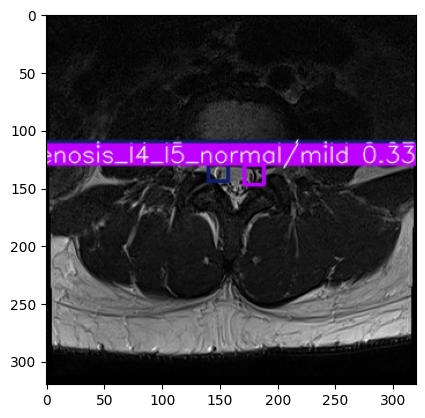

In [35]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)

In [36]:
!zip -r /kaggle/working/Subarticular_Stenosis_yolo.zip /kaggle/working/spine_detection/Subarticular_Stenosis_yolo

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/ (stored 0%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/confusion_matrix_normalized.png (deflated 17%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/val_batch2_pred.jpg (deflated 11%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/F1_curve.png (deflated 10%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/train_batch1.jpg (deflated 4%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/val_batch1_pred.jpg (deflated 12%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/labels_correlogram.jpg (deflated 61%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/val_batch0_pred.jpg (deflated 14%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/P_curve.png (deflated 9%)
  adding: kaggle/working/spine_detection/Subarticular_Stenosis_yolo/train_batch0.jpg (deflated 5%)
 